## **EXPLORATORY_ANALYSIS**

In [64]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from utils_cosm import MHI_Modi2019, MHI_Padmanabhan2017
import warnings
from helpers import *
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# Since we are working on a restricted version of the dataset, we should ensure that i_run belongs to [0,9]
# i_z belongs to [0,15]
# i_run refers to the choice of the cosmological and astrophysical constants. For each choice of such parameters, we have 16 subfiles corresponding 
# to different zs

i_run, i_z = 0, 0 # This means we work using LH_0 and z = 2.63

path_in = './outputs_test2/LH_%d/' %(i_run)
path_out = path_in

redshift = np.loadtxt('./outputs_test2/redshifts.txt', usecols=(1))
params = np.loadtxt('./outputs_test2/params_IllustrisTNG.txt')

z = redshift[i_z]
#t_back = cosmo.lookback_time(z).to(u.Myr)
print('z=%.3f' %(z))

print('Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2')
print(params[i_run])

z=2.630
Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2
[0.309   0.979   3.11234 1.12194 0.6685  0.53182]


In [66]:
# Importing data
f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))
mHalo = f['MassHalo'][:]
mHI = f['M_HI'][:]
f.close()

# Generating prediction produced by models currently used to approximate M_HI vs Mass_Halo relation
mass = np.logspace(8, 14, 1000)
mHI_modelA = MHI_Modi2019(Mh=mass, z=z, model='A')
mHI_modelC = MHI_Modi2019(Mh=mass, z=z, model='C')

mHI_Pad = MHI_Padmanabhan2017(Mh=mass, z=z, Om0=params[i_run, 0], delta_c=200.)

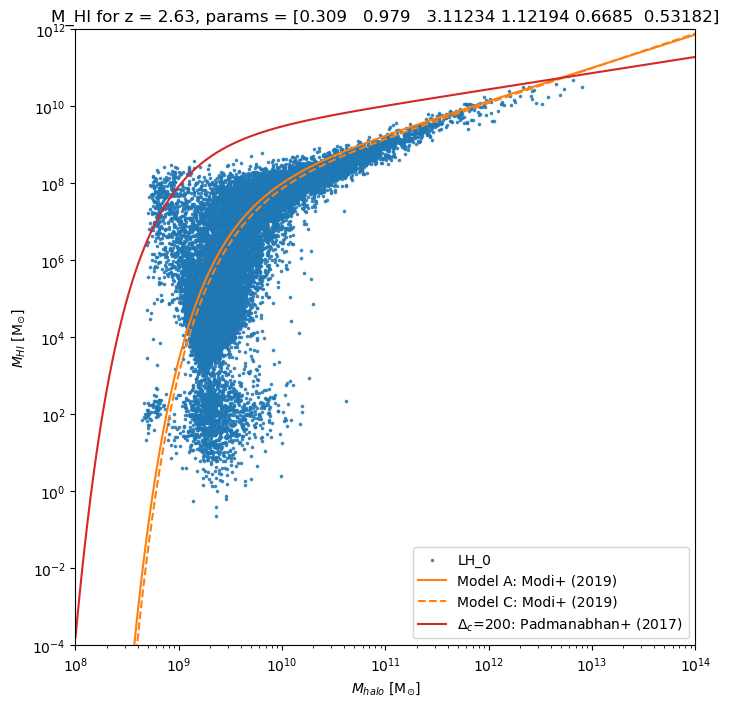

In [67]:
# Plotting the cloud of points and the different state of the art approximations
plt.figure(figsize = (8,8))
plt.title('M_HI for z = {}, params = {}'.format(z,params[i_run]))

plt.scatter(x=mHalo, y=mHI, s=10, color='tab:blue', label=r'LH_%d' %i_run, marker='.', alpha=0.8)
plt.plot(mass, mHI_modelA, label='Model A: Modi+ (2019)', color='tab:orange', ls='-')
plt.plot(mass, mHI_modelC, label='Model C: Modi+ (2019)', color='tab:orange', ls='--')
plt.plot(mass, mHI_Pad, label=r'$\Delta_c$=200: Padmanabhan+ (2017)', color='tab:red', ls='-')

plt.xscale('log'), plt.yscale('log')
plt.xlim(1e8, 1e14), plt.ylim(1e-4, 1e12)
plt.xlabel(r'$M_{halo}$ $\rm{[M_{\odot}]}$')
plt.ylabel(r'$M_{HI}$ $\rm{[M_{\odot}]}$')
plt.legend(loc=4)

plt.savefig('%scompare_MHI_LH%d_z%.3f.png' %(path_out, i_run, z), bbox_inches='tight', facecolor='white')
plt.show()

#### IMPORTING AND ANALYZING DATA

In [68]:
# Importing data
# Defining feature names

new_features = ['MassHalo','VelHalo','Nsubs','MassBH','dotMassBH','PosHalo',
                'MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0',
                'MetalsStar_1','MetalsStar_2','SFR','M_HI','Temp','Flux','Density']

# Defining a new dataset

f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))

MHalo = f['MassHalo']
VelHalo = f['VelHalo']
Nsubs = f['Nsubs']
MassBH = f['MassBH']
dotMassBH = f['dotMassBH']
posHalo = f['PosHalo']
MetalsGas = f['MetalsGas']
MetalsStar = f['MetalsStar']
SFR = f['SFR']
M_HI = f['M_HI']
Temp = f['Temp']
Flux = f['Flux']
Density = f['Density']


data = np.empty((MHalo.size,len(new_features)))

data[:,0] = MHalo

# Instead of saving the velocity of the Halo among each canonical direction, we decide to summarize them by compute 
# the euclidean norm of the velocity. By doing so, we not only reduce the dimension of our data (extremely useful to avoid the 
# curse of dimensionality), but we ensure to reduce the computation without losing useful information.

data[:,1] = np.linalg.norm(VelHalo, axis = 1)
data[:,2] = Nsubs
data[:,3] = MassBH
data[:,4] = dotMassBH

# Since the model does not take into account the interaction among different Halos, there is no need to save the coordinates
# along different dimension but it is enough to save the norm of the vector indicating the distance of the Halo from the
# centre of the simulation

data[:,5] = np.linalg.norm(posHalo, axis = 1)

data[:,6] = MetalsGas[:,0]
data[:,7] = MetalsGas[:,1]
data[:,8] = MetalsGas[:,2]
data[:,9] = MetalsStar[:,0]
data[:,10] = MetalsStar[:,1]
data[:,11] = MetalsStar[:,2]
data[:,12] = SFR
data[:,13] = M_HI
data[:,14] = Temp
data[:,15] = Flux
data[:,16] = Density

df_original = pd.DataFrame(data, columns = new_features)
print(df_original.describe())
df_original.sample(5)
df = df_original.copy()

           MassHalo       VelHalo         Nsubs        MassBH     dotMassBH  \
count  2.483800e+04  24838.000000  24838.000000  2.483800e+04  2.483800e+04   
mean   1.384219e+10    178.550590      0.939689  2.161897e+05  1.840804e+05   
std    1.200604e+11     88.485080      1.036897  8.205954e+06  9.247971e+06   
min    4.398577e+08      7.465858      0.000000  0.000000e+00  0.000000e+00   
25%    1.951664e+09    114.859684      1.000000  0.000000e+00  0.000000e+00   
50%    3.120521e+09    164.212830      1.000000  0.000000e+00  0.000000e+00   
75%    6.342715e+09    226.551731      1.000000  0.000000e+00  0.000000e+00   
max    7.991448e+12    690.334167     53.000000  8.933110e+08  1.264435e+09   

            PosHalo   MetalsGas_0   MetalsGas_1   MetalsGas_2  MetalsStar_0  \
count  24838.000000  24838.000000  24838.000000  2.483800e+04  24838.000000   
mean      23.559367      0.759575      0.240014  8.864283e-05      0.062024   
std        6.440471      0.013673      0.004344  4.

'MetalsGas' and 'MetalsStar' seem to be very concentrated unless for very few observations. We decide to visualize the distributions of these features to better understand how to handle them. The same thing happens for SFR ('Star Formation Rate') and 'Flux',whose values are mainly equal to zero.

In [69]:
df[['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']].describe()

,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2
count,24838.000000,24838.000000,2.483800e+04,24838.000000,24838.000000,24838.000000
mean,0.759575,0.240014,8.864283e-05,0.062024,0.019621,0.000045
std,0.013673,0.004344,4.858848e-04,0.207960,0.065787,0.000522
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.759998,0.240000,8.000000e-10,0.000000,0.000000,0.000000
50%,0.760000,0.240000,8.340466e-10,0.000000,0.000000,0.000000
75%,0.760000,0.240001,1.091075e-06,0.000000,0.000000,0.000000
max,0.760000,0.251941,1.432272e-02,0.760000,0.249917,0.021299


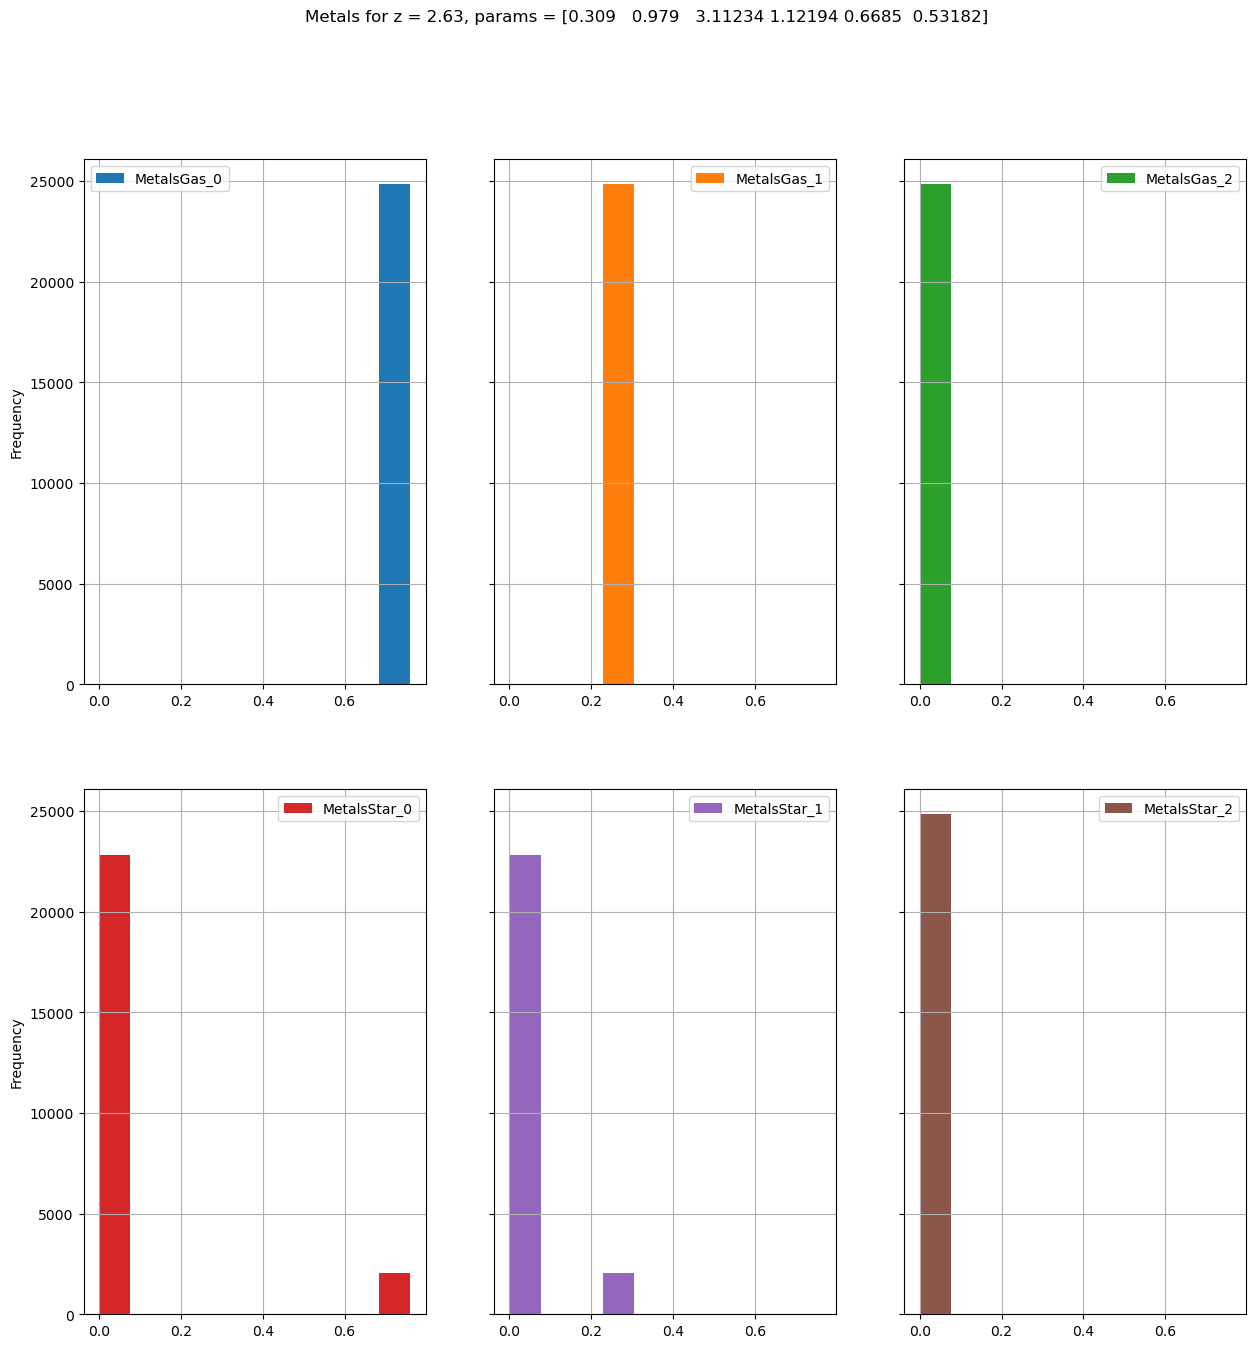

In [70]:
analysed_columns = ['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']
df[analysed_columns].plot(kind = 'hist',subplots = True, figsize = (15,15), layout = (2,3), sharey = True,
                          sharex = False, grid = True, title = 'Metals for z = {}, params = {}'.format(z,params[i_run]))
plt.show()

From the previous analysis we notice that, except for few observations, the analysed features tend to mantain the same value. Since they are not so discriminant, we avoid to use them in the following plot showing the distributions of each features and the scatter plot of every pair of variables. GIven the small discriminant and informative power, we decide not to use them in order to build our final models.

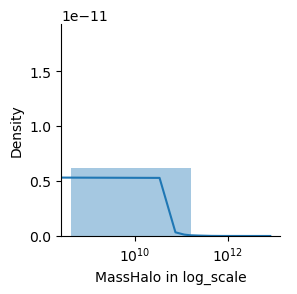

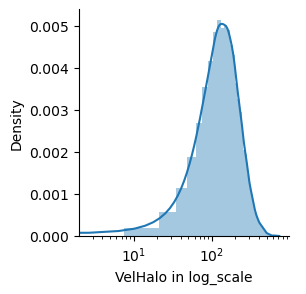

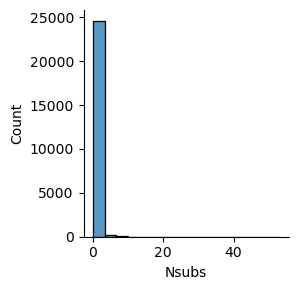

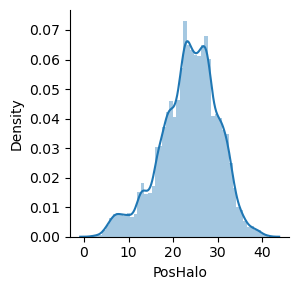

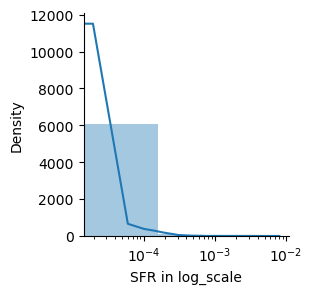

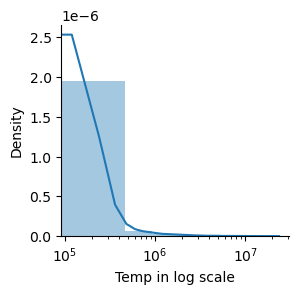

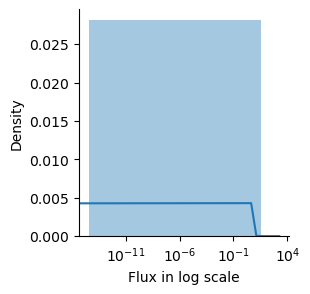

In [71]:
sns.FacetGrid(df,height=3).map(sns.distplot,"MassHalo").add_legend()
plt.xscale('log')
plt.xlabel('MassHalo in log_scale')
sns.FacetGrid(df,height=3).map(sns.distplot,"VelHalo").add_legend()
plt.xscale('log')
plt.xlabel('VelHalo in log_scale')
sns.FacetGrid(df,height=3).map(sns.histplot,"Nsubs").add_legend()
sns.FacetGrid(df,height=3).map(sns.distplot,"PosHalo").add_legend()
sns.FacetGrid(df,height=3).map(sns.distplot,"SFR").add_legend()
plt.xscale('log')
plt.xlabel('SFR in log_scale')
sns.FacetGrid(df,height=3).map(sns.distplot,"Temp").add_legend()
plt.xscale('log')
plt.xlabel('Temp in log scale')
sns.FacetGrid(df,height=3).map(sns.distplot,"Flux").add_legend()
plt.xscale('log')
plt.xlabel('Flux in log scale')
plt.show()

Since the position of the halo is related to its distance from the centre of the simulation and it is not related to any physical property of the halo, we decide to drop this variable since it is not discriminant and significant for the problem. This choice is also useful in order to remove useless dimensions that might affect K-Means Clustering computation.

#### K-MEANS CLUSTERING ALGORITHM

Supposing not to know the actual value of M_HI, we want to use an unsupervised learning algorithm to label each data point depending on the quantity of Hydrogen in the corresponding Halo. Therefore, we want to capture patterns and similarities in the data related to their features.

We define the dataset we need. Considering the observations above, we decide not to consider MetalsGas, MetalsStar and PosHalo  since they do not seem to carry useful information. Dimensionality reduction, provided that it does not waste any useful information, is a great way to avoid the curse of dimensionality when using KMeansClutering. Before starting, we notice two main problems:
- MassHalo must be rescaled since its values are far higher than the others. If we do not do so, the method will overoptimize w.r.t this only variable;
​
​
- we need to rescale the other mass values so that we can consider only their magnitude;
​
​
- using a 1-hot encoding to deal with Nsubs is not efficient (the dimension of the feature space grows and we suffer from the Curse of Dimensionality)

In [83]:
# We now define two useful dataframes. X will have normalized features. The plot above justifies our choice
X = df[['MassHalo','MassBH','dotMassBH','SFR','Nsubs','VelHalo','Flux','Temp','Density']]
feature_matrix = X.copy()
X['MassHalo'] = np.log10(X.MassHalo)
X['dotMassBH'] = np.log10(1 + X.dotMassBH)
X['MassBH'] = np.log10(1 + X.MassBH)
X['VelHalo'] = np.log10(1 + X.VelHalo)
X['Temp'] = np.log10(1 + X.Temp)
X['Density'] = np.log10(1 + X.Density)
X = (X - X.mean()) / (X.std())
X.head()

,MassHalo,MassBH,dotMassBH,SFR,Nsubs,VelHalo,Flux,Temp,Density
0,7.168572,7.552946,8.941572,2.550148,50.207775,-0.522973,-0.006940,4.215247,4.145142
1,6.979418,7.190452,10.639494,18.823865,42.492450,-0.077953,0.346768,3.974211,5.517114
2,6.872502,7.080316,11.753337,31.220743,30.919463,0.305728,153.578393,4.099272,5.682353
3,6.777977,7.260091,10.738031,24.620338,26.097385,-0.986587,0.476929,3.981176,5.356710
4,6.705832,7.818657,9.872143,3.718507,35.741541,-2.050035,0.051241,3.703279,4.199996


We train various models saving the corresponding inertia (weighted sum of squared distances of points from their centroids).
We use k-means++ to initialize our centroids in a clever way.

In [84]:
# We define a list to later store the inertia values corresponding to each model
wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

We now visualize the curve in order to choose the optimal K (hyperparameter).

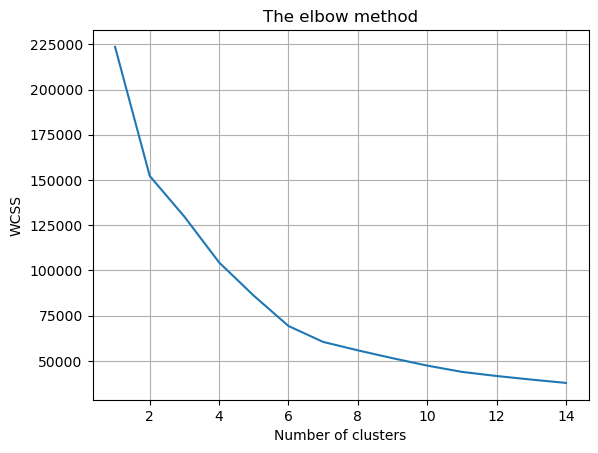

In [86]:
plt.plot(range(1, 15), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.grid()
plt.show()

K = 5 appear to be a good choice, since the curve reaches its plateau. It would be interesting to see whether this implies that the features are discriminant enough to classify data in five ordered groups depending on the magnitude of the Hydrogen Mass.

After choosing the best K, we proceed to use KMeansClustering to assign a label to each data point.

In [89]:
# Defining final model using the best hyperparameter
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

#### Visualizing clusters in the initial cloud of points

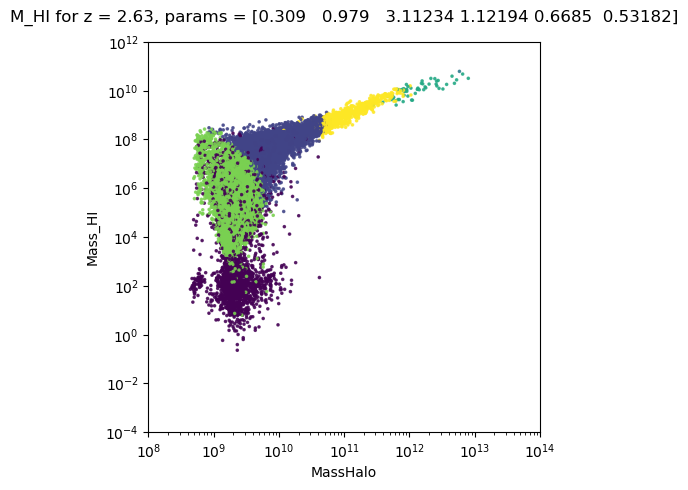

In [90]:
# Plotting the cloud of points, this time using colors to represent different categories found by the unsupervised algorithm
fig,axs = plt.subplots(1, figsize = (5,5))

# Initial data
axs.scatter(x=mHalo, y=mHI, s=10, c=y_kmeans, label=r'LH_%d' %i_run, marker='.', alpha=0.8,)
axs.set(xscale='log',yscale='log', xlim=(1e8, 1e14), ylim=(1e-4, 1e12), xlabel='MassHalo', ylabel='Mass_HI')
axs.set_title('M_HI for z = {}, params = {}'.format(z,params[i_run]), y = 1.03)

plt.savefig('%scompare_MHI_LH%d_z%.3f.png' %(path_out, i_run, z), bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()

The plot above shows that KMC performs quite well on this task: points seem to be divided by orizontal lines depending on the magnitude of Mass_HI. There are still some problems and a possible reason might be the following: our data do not have enough spatial correlation, which is a fundamental assumption when using K-Mean Clustering.

Finally, we can strongly conclude that the features we decided to use reveal to be good explanatory variables. When working with the final architecture (Fully Connected Neural Network), we will decide whether to keep or to drop the features we classified as meaningless.